In [1]:
import IPython
import matplotlib
import os
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.distance import cdist
import numpy as np
import cv2
from ipywidgets import interact, fixed, FloatSlider, IntSlider, Checkbox, FloatRangeSlider

In [2]:
train_weights = {}
test_weights = {}
train_eigen_face_vec = {}
eigen_vec_error_dict = {}

In [3]:
def load_images(path):
    file_dic = {}
    sub_directory = []
    image_list = []
    id_list = []
    for subdir, dirs, files in os.walk(path):
        for file in files:
            split_list = file.split("_")
            id = split_list[0]
            id_list.append(id)
            if file.find("jpg") > -1:
                if subdir in file_dic:
                    file_dic[subdir].append(os.path.join(subdir, file))
                    image = (cv2.imread(os.path.join(subdir, file), 0)) / 255.
                    image_list.append(image)
                else:
                    sub_directory.append(subdir)
                    file_dic[subdir] = [os.path.join(subdir, file)]
                    image = (cv2.imread(os.path.join(subdir, file), 0)) / 255.
                    image_list.append(image)
    return image_list, file_dic, sub_directory, id_list

In [4]:
def display_images(image_list, title):
    fig1, axes_array = plt.subplots(5, 5)
    fig1.set_size_inches(5, 5)
    i = 0
    for row in range(0, 5):
        for col in range(0, 5):
            image = cv2.resize(image_list[i], (100, 100))
            axes_array[row, col].imshow(image, cmap=plt.cm.gray)
            axes_array[row, col].axis('off')
            i += 1
    plt.suptitle(title)
    plt.show()

In [5]:
def calculate_covariance(matrix):
    return np.cov(matrix, rowvar=False)

In [6]:
def calculate_image_vector_matrix(image_list):
    # =============================================================
    #               calculating FACE VECTOR
    # =============================================================
    val_1, val_2 = image_list[0].shape
    rows = val_1 * val_2
    image_vec_matrix = np.zeros((rows, len(image_list)))
    i = 0
    for image in image_list:
        vector = image.flatten()
        vector = np.asmatrix(vector)
        image_vec_matrix[:, i] = vector
        i += 1
    return image_vec_matrix

In [7]:
def calculate_mean_face(image_vec_matrix):
    # =============================================================
    #              calculating MEAN FACE VECTOR
    # =============================================================
    mean_face_vec = np.mean(image_vec_matrix, axis=1)
    mean_face_vec = np.asmatrix(mean_face_vec)

    # =============================================================
    #               calculating MEAN FACE IMAGE
    # =============================================================
    mean_face_img = np.reshape(mean_face_vec, (size, size))
    plt.imshow(cv2.resize(mean_face_img, (100, 100)), cmap='gray')
    plt.suptitle("Mean Face Image")
    plt.show()

    return mean_face_vec

In [8]:
def store_weights(k, zero_mean_face_matrix):
    k_eigen_faces_vec = train_eigen_face_vec[k]
    # =============================================================
    #          				Calculate WEIGHTS
    # =============================================================
    k_weights = np.dot(k_eigen_faces_vec, zero_mean_face_matrix)
    k_weights = np.transpose(k_weights)
    test_weights[k] = k_weights

In [9]:
def reconstruct(k, eig_vec, zero_mean_face_matrix, mean_face_vec):
    k_faces = []
    # =============================================================
    #              Pick first K EIGEN VECTOR
    # =============================================================
    k_eig_vec = eig_vec[0: k, :]

    # =============================================================
    #          Calculate EIGEN FACES from K EIGEN VECTOR
    # =============================================================
    k_eigen_faces_vec = np.dot(zero_mean_face_matrix, k_eig_vec.T)
    k_eigen_faces_vec = np.transpose(k_eigen_faces_vec)
    train_eigen_face_vec[k] = k_eigen_faces_vec
    # =============================================================
    #          Calculate WEIGHTS
    # =============================================================
    k_weights = np.dot(k_eigen_faces_vec, zero_mean_face_matrix)
    k_weights = np.transpose(k_weights)
    train_weights[k] = k_weights

    # ==============================================================
    #          Perform Reconstruction
    # ===========q==================================================
    if k == 2 or k == 5 or k == 15:
        k_reconstruction = mean_face_vec + np.dot(k_weights, k_eigen_faces_vec)
        k_reconstruction = np.transpose(k_reconstruction)

        for face in range(0, k_reconstruction.shape[1]):
            k_faces.append(np.reshape(k_reconstruction[:, face], (size, size)))

        # =============================================================
        #          		       Display Eigen FACES
        # =============================================================
        display_images(k_faces, "Reconstructed Images with " + str(k) + " eigen vectors")

In [10]:
def get_zero_mean_face_matrix(image_vec_matrix, mean_face_vec):
    # =============================================================
    #      calculating zero_mean_face_matrix and Covariance
    # =============================================================
    zero_mean_face_matrix = []
    count = 0
    loop_end = np.shape(image_vec_matrix)[1]
    for i in range(loop_end):
        image_col_vector = image_vec_matrix[:, i]
        image_col_vector = image_col_vector - mean_face_vec

        if count == 0:
            zero_mean_face_matrix = image_col_vector
            count += 1
        else:
            zero_mean_face_matrix = np.vstack((zero_mean_face_matrix, image_col_vector))

    zero_mean_face_matrix = zero_mean_face_matrix.T
    return zero_mean_face_matrix

In [11]:
def euclidean(test_weight, training_weights, train_images, test_img, k, l, acc, thr):
    # =============================================================
    #              calculating Euclidean Distance
    # =============================================================
    dist = []
    for weight in range(0, training_weights.shape[0]):
        dist.append(cdist(np.asmatrix(test_weight), np.asmatrix(training_weights[weight, :]), 'euclidean'))
    closest = dist.index(min(dist))
    # =============================================================
    #                   Performing Classification
    # =============================================================
    if min(dist) > thr and thr !=0 :
        if test_id_list[l] == "S099" or train_id_list[l] not in train_id_list:
            acc += 1
        if k == 2 or k == 5 or k == 15:
            print("Eigen_Vectors Used are %d"%(k),"distance calculated is %d"% (min(dist)))
            fig1, axes_array = plt.subplots(1, 2)
            fig1.set_size_inches(5, 5)
            axes_array[0].imshow(test_img, cmap=plt.cm.gray)
            axes_array[0].axis('off')
            axes_array[0].title.set_text('Test_Image')
            axes_array[1].imshow(np.zeros((425, 425)), cmap=plt.cm.gray)
            axes_array[1].axis('off')
            axes_array[1].title.set_text('Non-Face or Uknown')

    elif test_id_list[l] == train_id_list[closest]:
        acc += 1

        if k == 2 or k == 5 or k == 15:
            print("Eigen_Vectors Used are %d"%(k),"distance calculated is %d"% (min(dist)))
            fig1, axes_array = plt.subplots(1, 2)
            fig1.set_size_inches(5, 5)
            axes_array[0].imshow(test_img, cmap=plt.cm.gray)
            axes_array[0].axis('off')
            axes_array[0].title.set_text('Test_Image')
            axes_array[1].imshow(train_images[closest], cmap=plt.cm.gray)
            axes_array[1].axis('off')
            axes_array[1].title.set_text('Classified_Image')

    elif test_id_list[l] != train_id_list[closest]:
        if k == 2 or k == 5 or k == 15: 
            print("Eigen_Vectors Used are %d"%(k),"distance calculated is %d"% (min(dist)))
            fig1, axes_array = plt.subplots(1, 2)
            fig1.set_size_inches(5, 5)
            axes_array[0].imshow(test_img, cmap=plt.cm.gray)
            axes_array[0].axis('off')
            axes_array[0].title.set_text('Test_Image')
            axes_array[1].imshow(train_images[closest], cmap=plt.cm.gray)
            axes_array[1].axis('off')
            axes_array[1].title.set_text('Classified_Image')
    plt.show()
    return acc

In [12]:
def get_eig_vectors(zero_mean_face_matrix, mean_face_vec):
    # zero_mean_face_matrix = image_vec_matrix - mean_face_vec
    covariance = calculate_covariance(zero_mean_face_matrix)
    # =============================================================
    #      			   calculating Eigen Faces
    # =============================================================
    eig_values, eig_vectors = np.linalg.eig(covariance)
    eig_faces_vec = np.dot(zero_mean_face_matrix, eig_vectors)
    eig_face = []
    for face in range(0, eig_faces_vec.shape[1]):
        eig_face.append(np.reshape(eig_faces_vec[:, face], (size, size)))

    # =============================================================
    #      			   Displaying Eigen Faces
    # =============================================================
    display_images(eig_face, "Eigen Faces")

    # =============================================================
    #      				Sorting Eigen Values
    # =============================================================
    eig_values, eig_vectors = zip(*sorted(zip(eig_values, eig_vectors)))
    eig_values = np.asarray(list(eig_values[::-1]))
    eig_vectors = np.asarray(list(eig_vectors[::-1]))
    return eig_vectors


<class 'list'>
25


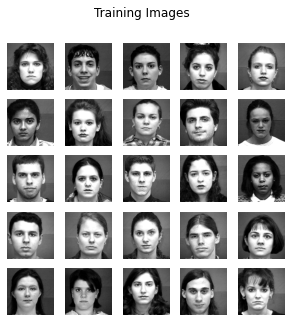

In [13]:
size = 425
# =============================================================
#      						Training
# =============================================================
train_path = "/home/billycoder13/Documents/Github/Personal_CV_Projects/00_DATA/Eigenfaces/Train"
train_img_list, train_file_dict, train_sub_dir, train_id_list = load_images(train_path)
print(type(train_img_list))
print(len(train_img_list))
display_images(train_img_list, "Training Images")


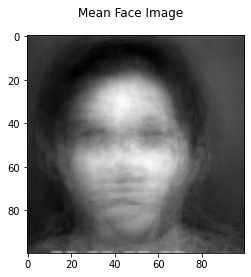

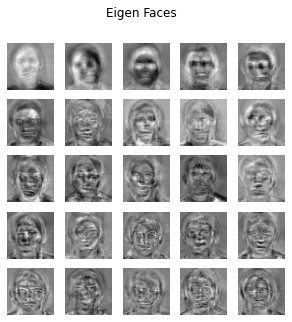

In [14]:
train_image_vector_matrix = calculate_image_vector_matrix(train_img_list)
train_mean_face_vector = calculate_mean_face(train_image_vector_matrix)
train_zero_mean_face_matrix = get_zero_mean_face_matrix(train_image_vector_matrix, train_mean_face_vector)




eig_vectors = get_eig_vectors(train_zero_mean_face_matrix, train_mean_face_vector)

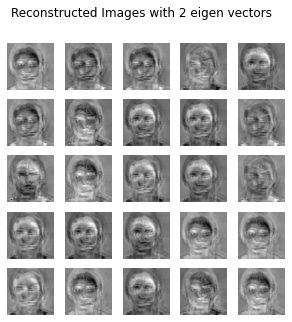

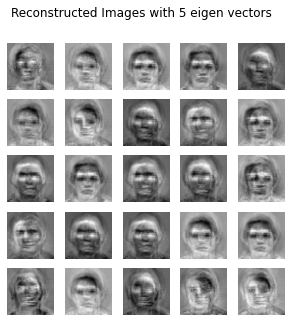

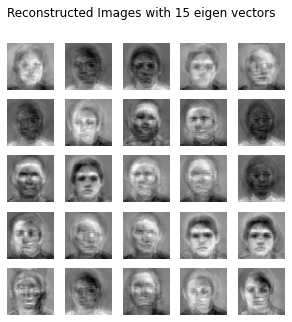

In [15]:
for i in range(len(train_img_list)):
    reconstruct(i+1, eig_vectors, train_zero_mean_face_matrix, train_mean_face_vector)

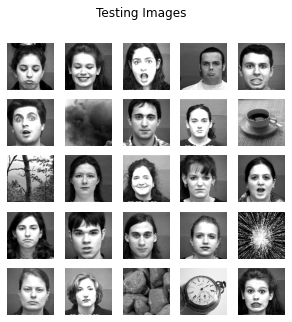

In [18]:
# =============================================================
#                            Testing
# =============================================================
test_path = "/home/billycoder13/Documents/Github/Personal_CV_Projects/00_DATA/Eigenfaces/Test"
test_img_list, test_file_dict, test_sub_dir, test_id_list = load_images(test_path)
display_images(test_img_list, "Testing Images")
test_image_vector_matrix = calculate_image_vector_matrix(test_img_list)
test_zero_mean_face_matrix = get_zero_mean_face_matrix(test_image_vector_matrix, train_mean_face_vector)
for i in range(0, len(train_img_list)):
    store_weights(i+1, test_zero_mean_face_matrix)

In [20]:
print(len(train_img_list))
print(len(test_img_list))

25
32


In [21]:
def classifying(thr = 0):
    error_rate = []
    k_eigen = []
    for i in range(0, len(train_img_list)):
        acc = 0
        # make the iteration range equal the len(train_img_list) 
        for j in range(0, len(test_img_list) - 7):
            acc = euclidean(test_weights[i+1][j, :], train_weights[i+1], train_img_list, test_img_list[j], i+1, j, acc, thr) 
        if thr != 0 : 
            thr += 200
        acc /= len(test_img_list)
        eigen_vec_error_dict[i + 1] = 1 - acc
        k_eigen.append(i + 1)
        error_rate.append(1 - acc)
    plt.plot(k_eigen, error_rate, marker = 'o')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.title('Classification error rate as a function of eigen vector')
    plt.show()
temp=interact(classifying,thr = IntSlider(min=0, max=5000, step=500, value=1000, continuous_update=False));

interactive(children=(IntSlider(value=1000, continuous_update=False, description='thr', max=5000, step=500), O…